Importint the Libraries

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import ShuffleSplit



Loading Dataset

In [44]:
# Load dataset
data = load_breast_cancer()

# Convert to Pandas DataFrame for better analysis
df = pd.DataFrame(data.data, columns=data.feature_names)

# Add the target column
df['target'] = data.target

# Display basic info
print(df.info())
print(df.head())


# Check class distribution
print(df['target'].value_counts())  # Should show imbalance (357 benign, 212 malignant)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

Visualizing a Decision Tree Model:
The goal here isn’t to optimize for performance but rather to visualize the decision boundaries and understand how the tree splits the features. This helps confirm that the features are meaningful before we start stacking multiple models together.

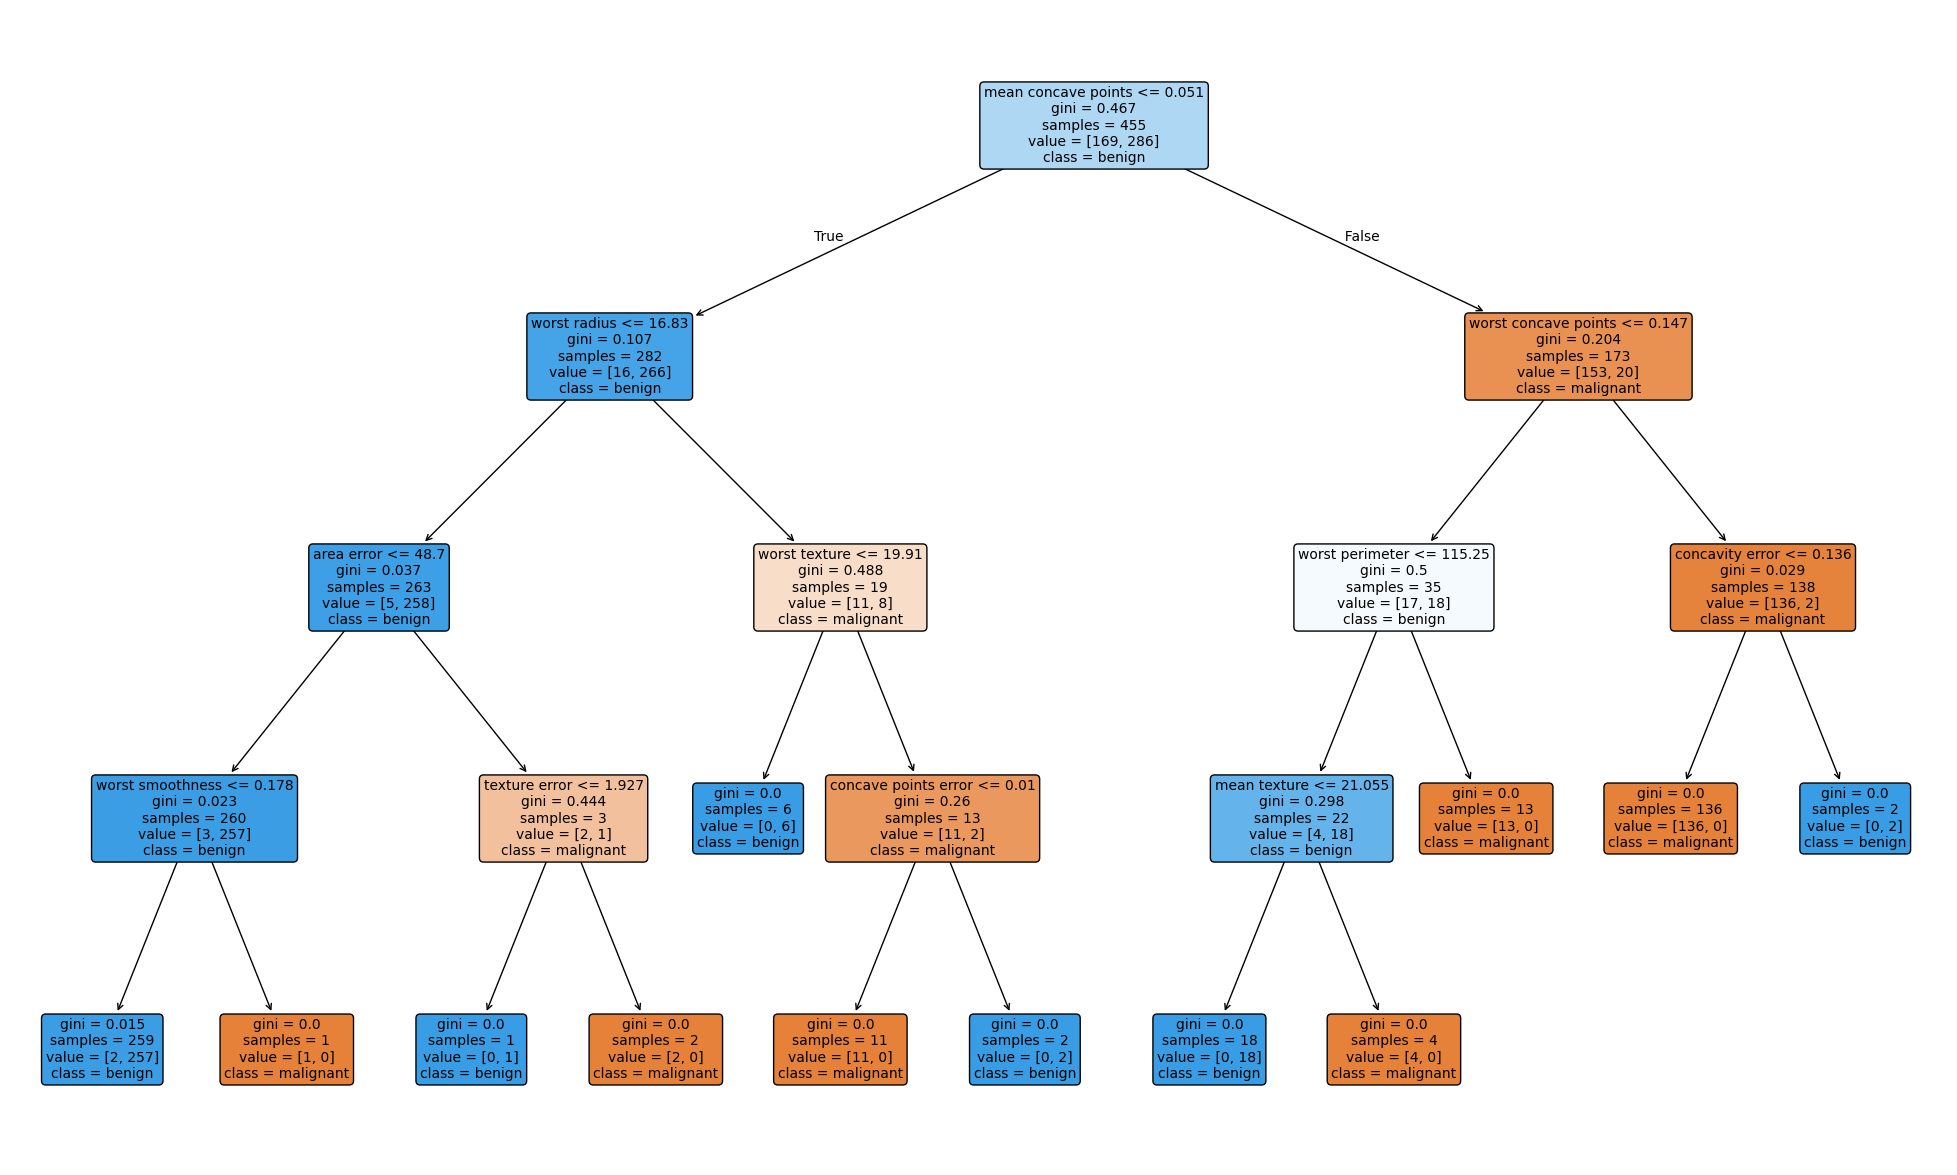

In [54]:
X, y = data.data, data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Model
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=42)  # Adjust max_depth for complexity
dt.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(25, 15))
plot_tree(dt, filled=True, feature_names=data.feature_names, class_names=data.target_names, rounded=True, fontsize=10)
plt.show()

Random Forest Feature Importance Visualization

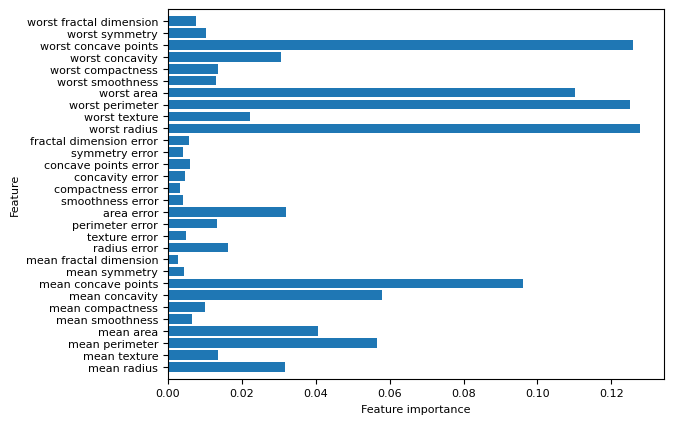

In [60]:

def plot_feature_importances_cancer(model):
    n_features = data.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)


X, y = data.data, data.target
forest = RandomForestClassifier(random_state=0, n_estimators=256, n_jobs=-1)
forest.fit(X,y)
plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(forest)

Bias-Variance Trade-off Visualization using Random Forest

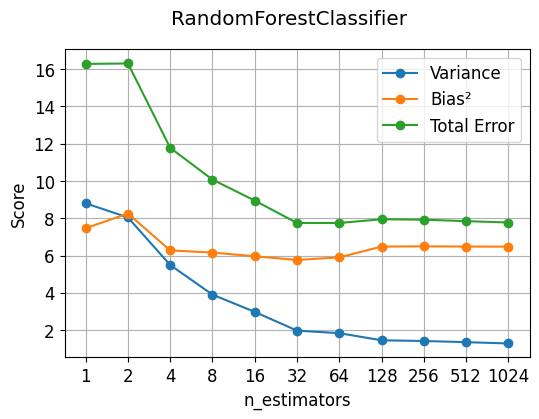

In [63]:
def compute_bias_variance(clf, X, y):
    n_repeat = 40 
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    y_all_pred = [[] for _ in range(len(y))]

    for train_index, test_index in shuffle_split.split(X):
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        for j, index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    bias_sq = sum([(1 - x.count(y[i]) / len(x))**2 * len(x) / n_repeat for i, x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0) / len(x))**2 + (x.count(1) / len(x))**2)) / 2)
               * len(x) / n_repeat for i, x in enumerate(y_all_pred)])
    error = sum([(1 - x.count(y[i]) / len(x)) * len(x) / n_repeat
                 for i, x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

# Function to plot Bias-Variance tradeoff
def plot_bias_variance_rf(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []

    # Generate n_estimators dynamically using powers of 2
    n_estimators = [2**x for x in range(0, 11)]  # 2^0 to 2^10 → [1, 2, 4, ..., 1024]

    for i in n_estimators:
        b, v, e = compute_bias_variance(clf.set_params(random_state=0, n_estimators=i), X, y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(6, 4))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)

    plt.plot(n_estimators, var_scores, label="Variance", marker="o")
    plt.plot(n_estimators, np.square(bias_scores), label="Bias²", marker="o")
    plt.plot(n_estimators, err_scores, label="Total Error", marker="o")

    # Use base-2 log scale
    plt.xscale('log', base=2)
    plt.xticks(n_estimators, labels=[str(n) for n in n_estimators])  # Explicit labels

    plt.xlabel("n_estimators")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


X, y = data.data, data.target

# Train and plot
rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
plot_bias_variance_rf(rf, X, y)


Moving into the Stacking Model

Dropping Irrelevant Features

In [70]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

irrelevant_features = ['mean perimeter', 'mean smoothness', 'mean compactness', 'mean symmetry']
df = df.drop(columns=irrelevant_features)

X = df.drop(columns=['target'])
y = df['target']


I dropped a few features that seemed redundant or less helpful. ‘Mean perimeter’ was highly correlated with ‘mean radius’, so I kept just one. ‘Mean compactness’ and ‘mean symmetry’ showed low importance, so I removed them. ‘Mean smoothness’ had low variance, so it was dropped as well. This isn’t mandatory, but it simplifies the model and reduces noise.

Applying SMOTE for Class Imbalance

In [71]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print(f"Before SMOTE: {y.value_counts().to_dict()}")
print(f"After SMOTE: {pd.Series(y_resampled).value_counts().to_dict()}")


Before SMOTE: {1: 357, 0: 212}
After SMOTE: {0: 357, 1: 357}


e:\VIT Vellore\ml\project\ensemble\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


 We applied SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution by generating synthetic samples.
 This is super important when the dataset is skewed, like in this case.

Splitting the Data

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


Standardizing the Features

In [73]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


1. Using RFs only for Ensemble
2. SVC as Meta model
3. Eval using Confusion Matrix on train as well as test data

K-Fold Cross Validation with Random Forest Base Learners and SVC Meta Learner

In [74]:
# K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
base_learners = []
meta_train_data = np.zeros((X_train.shape[0], 5)) # Store base learners' predictions

# Added list to store individual RF accuracies
base_rf_accuracies = []
print("Base Learner (Random Forest) Training & Evaluation")

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Initialize and train the base learner (Random Forest)
    rf = RandomForestClassifier(n_estimators=88, random_state=42)
    rf.fit(X_train_fold, y_train_fold.values)
    base_learners.append(rf)

    # Calculate and store accuracy for this fold's RF model
    # Predict on the validation set for this fold
    y_pred_fold = rf.predict(X_val_fold)
    # Calculate accuracy against the true validation labels
    fold_accuracy = accuracy_score(y_val_fold.values, y_pred_fold)
    base_rf_accuracies.append(fold_accuracy)
    print(f"Fold {i+1} RF Accuracy (on validation set): {fold_accuracy:.4f}")
 

    # Store probabilities for the meta-learner training data
    meta_train_data[val_index, i] = rf.predict_proba(X_val_fold)[:, 1]

# --- Print average accuracy of base learners ---
print(f"\nAverage Base Learner (RF) Accuracy: {np.mean(base_rf_accuracies):.4f}")
print()

# Meta-learner (SVM)
print("\nMeta Learner (SVM) Training & Evaluation")
meta_learner = SVC(C=1, random_state=42) # Using C=5 as per previous example
meta_learner.fit(meta_train_data, y_train.values)

# Generate meta-features for the test set
meta_test_data = np.zeros((X_test.shape[0], 5))
for i, rf_learner in enumerate(base_learners):
    meta_test_data[:, i] = rf_learner.predict_proba(X_test)[:, 1]

# Make final predictions using the meta-learner
y_pred = meta_learner.predict(meta_test_data)

# Evaluate overall stacking model performance
print("\nStacking Model Final Accuracy (on test set):", accuracy_score(y_test, y_pred))
print("\nStacking Model Classification Report (on test set):\n", classification_report(y_test, y_pred))

Base Learner (Random Forest) Training & Evaluation
Fold 1 RF Accuracy (on validation set): 0.9913
Fold 2 RF Accuracy (on validation set): 0.9649
Fold 3 RF Accuracy (on validation set): 0.9737
Fold 4 RF Accuracy (on validation set): 0.9737
Fold 5 RF Accuracy (on validation set): 0.9298

Average Base Learner (RF) Accuracy: 0.9667


Meta Learner (SVM) Training & Evaluation

Stacking Model Final Accuracy (on test set): 0.9020979020979021

Stacking Model Classification Report (on test set):
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        72
           1       0.84      1.00      0.91        71

    accuracy                           0.90       143
   macro avg       0.92      0.90      0.90       143
weighted avg       0.92      0.90      0.90       143



In the above cell, we set up K-fold cross-validation to train base learners (Random Forest) on different subsets of the training data. Each base learner’s predictions are stored, and we calculate the average accuracy for them. Next, we create a meta-learner (SVM, as it is one of best model for Non-Linear Dataset) using the predictions of the base learners and train it to make final predictions. The model's performance is evaluated using accuracy and a classification report.

Using GridSearchCV with same number of Folds and Decision Trees

In [75]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
base_learners = []
meta_train_data = np.zeros((X_train.shape[0], 5))

base_rf_accuracies = []
param_grid_rf = {'n_estimators': [22, 50, 100, 200]}  # Define parameter grid for RF

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Use GridSearchCV for Random Forest
    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                                  param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)  # cv=3 for faster execution
    grid_search_rf.fit(X_train_fold, y_train_fold.values)
    rf = grid_search_rf.best_estimator_  # Use best estimator from grid search
    print(f"Fold {i+1} - Best RF n_estimators: {grid_search_rf.best_params_['n_estimators']}")

    base_learners.append(rf)
    fold_accuracy = accuracy_score(y_val_fold.values, rf.predict(X_val_fold))
    base_rf_accuracies.append(fold_accuracy)
    meta_train_data[val_index, i] = rf.predict_proba(X_val_fold)[:, 1]

print(f"Average Base Learner (RF) Accuracy: {np.mean(base_rf_accuracies):.4f}")

param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']}
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(meta_train_data, y_train.values)
meta_learner = grid_search.best_estimator_
print("Best Meta-Learner (SVM) Parameters:", grid_search.best_params_)

meta_test_data = np.zeros((X_test.shape[0], 5))
for i, rf_learner in enumerate(base_learners):
    meta_test_data[:, i] = rf_learner.predict_proba(X_test)[:, 1]

y_pred = meta_learner.predict(meta_test_data)
print("\nStacking Model Final Accuracy (on test set):", accuracy_score(y_test, y_pred))
print("\nStacking Model Classification Report (on test set):\n", classification_report(y_test, y_pred))

Fold 1 - Best RF n_estimators: 50
Fold 2 - Best RF n_estimators: 100
Fold 3 - Best RF n_estimators: 50
Fold 4 - Best RF n_estimators: 200
Fold 5 - Best RF n_estimators: 50
Average Base Learner (RF) Accuracy: 0.9667
Best Meta-Learner (SVM) Parameters: {'C': 0.1, 'kernel': 'rbf'}

Stacking Model Final Accuracy (on test set): 0.9020979020979021

Stacking Model Classification Report (on test set):
               precision    recall  f1-score   support

           0       1.00      0.81      0.89        72
           1       0.84      1.00      0.91        71

    accuracy                           0.90       143
   macro avg       0.92      0.90      0.90       143
weighted avg       0.92      0.90      0.90       143



In the above cell we integrated GridSearchCV to find the best hyperparameters for both the Random Forest and SVM models. We tune the number of estimators in the Random Forest and the regularization parameter (C) and kernel for the SVM. The final model's performance is evaluated on the test set, and the best hyperparameters are printed out.

Observation: Using GridSearchCV with same number of Folds and Decision Trees does not affect the accuracy much.

Reducing the Number of folds

In [76]:
NUM_FOLDS = 2  # Number of K-folds
NUM_ESTIMATORS = 50 # Number of trees in the Random Forest
META_LEARNER_C = 0.1 # C parameter for the meta-learner SVM



# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K-fold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
base_learners = []
meta_train_data = np.zeros((X_train.shape[0], NUM_FOLDS))  # Store base learners' predictions

base_rf_accuracies = []
print("--- Base Learner (Random Forest) Training & Evaluation ---")

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    rf = RandomForestClassifier(n_estimators=NUM_ESTIMATORS, random_state=42)
    rf.fit(X_train_fold, y_train_fold.values)
    base_learners.append(rf)


    y_pred_fold = rf.predict(X_val_fold)
    fold_accuracy = accuracy_score(y_val_fold.values, y_pred_fold)
    base_rf_accuracies.append(fold_accuracy)
    print(f"Fold {i+1} RF Accuracy (on validation set): {fold_accuracy:.4f}")

    meta_train_data[val_index, i] = rf.predict_proba(X_val_fold)[:, 1]

# --- Print average accuracy of base learners ---
print(f"\nAverage Base Learner (RF) Accuracy: {np.mean(base_rf_accuracies):.4f}")
print()

# Meta-learner (SVM)
print("\nMeta Learner (SVM) Training & Evaluation")
meta_learner = SVC(C=META_LEARNER_C, random_state=42)
meta_learner.fit(meta_train_data, y_train.values)

# Generate meta-features for the test set
meta_test_data = np.zeros((X_test.shape[0], NUM_FOLDS))
for i, rf_learner in enumerate(base_learners):
    meta_test_data[:, i] = rf_learner.predict_proba(X_test)[:, 1]

# Make final predictions using the meta-learner
y_pred = meta_learner.predict(meta_test_data)

# Evaluate overall stacking model performance
print("\nStacking Model Final Accuracy (on test set):", accuracy_score(y_test, y_pred))
print("\nStacking Model Classification Report (on test set):\n", classification_report(y_test, y_pred))

--- Base Learner (Random Forest) Training & Evaluation ---
Fold 1 RF Accuracy (on validation set): 0.9650
Fold 2 RF Accuracy (on validation set): 0.9439

Average Base Learner (RF) Accuracy: 0.9544


Meta Learner (SVM) Training & Evaluation

Stacking Model Final Accuracy (on test set): 0.9300699300699301

Stacking Model Classification Report (on test set):
               precision    recall  f1-score   support

           0       1.00      0.86      0.93        72
           1       0.88      1.00      0.93        71

    accuracy                           0.93       143
   macro avg       0.94      0.93      0.93       143
weighted avg       0.94      0.93      0.93       143



Removing K-Folds, and tuning the number of trees as the dataset we used is Small.

In [77]:
from sklearn.model_selection import GridSearchCV

# Adjustable parameters 
NUM_FOLDS = 2  


# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# K-fold cross-validation
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
base_learners = []
meta_train_data = np.zeros((X_train.shape[0], NUM_FOLDS))

base_rf_accuracies = []
print("--- Base Learner (Random Forest) Training & Evaluation ---")

for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    param_grid_rf = {'n_estimators': [50, 100, 200]}
    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42),
                                  param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search_rf.fit(X_train_fold, y_train_fold.values)
    rf = grid_search_rf.best_estimator_
    print(f"Fold {i+1} - Best RF n_estimators: {grid_search_rf.best_params_['n_estimators']}")

    base_learners.append(rf)
    y_pred_fold = rf.predict(X_val_fold)
    fold_accuracy = accuracy_score(y_val_fold.values, y_pred_fold)
    base_rf_accuracies.append(fold_accuracy)
    print(f"Fold {i+1} RF Accuracy (on validation set): {fold_accuracy:.4f}")

    meta_train_data[val_index, i] = rf.predict_proba(X_val_fold)[:, 1]


print(f"\nAverage Base Learner (RF) Accuracy: {np.mean(base_rf_accuracies):.4f}")
print()


print("\nMeta Learner (SVM) Training & Evaluation")

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(meta_train_data, y_train.values)
meta_learner = grid_search_svm.best_estimator_
print("Best Meta-Learner (SVM) Parameters:", grid_search_svm.best_params_)

# Generate meta-features for the test set
meta_test_data = np.zeros((X_test.shape[0], NUM_FOLDS))
for i, rf_learner in enumerate(base_learners):
    meta_test_data[:, i] = rf_learner.predict_proba(X_test)[:, 1]

# Make final predictions using the meta-learner
y_pred = meta_learner.predict(meta_test_data)

# Evaluate overall stacking model performance
print("\nStacking Model Final Accuracy (on test set):", accuracy_score(y_test, y_pred))
print("\nStacking Model Classification Report (on test set):\n", classification_report(y_test, y_pred))

--- Base Learner (Random Forest) Training & Evaluation ---
Fold 1 - Best RF n_estimators: 50
Fold 1 RF Accuracy (on validation set): 0.9650
Fold 2 - Best RF n_estimators: 200
Fold 2 RF Accuracy (on validation set): 0.9404

Average Base Learner (RF) Accuracy: 0.9527


Meta Learner (SVM) Training & Evaluation
Best Meta-Learner (SVM) Parameters: {'C': 10, 'kernel': 'rbf'}

Stacking Model Final Accuracy (on test set): 0.9300699300699301

Stacking Model Classification Report (on test set):
               precision    recall  f1-score   support

           0       0.98      0.88      0.93        72
           1       0.89      0.99      0.93        71

    accuracy                           0.93       143
   macro avg       0.94      0.93      0.93       143
weighted avg       0.94      0.93      0.93       143



Observation Removing K-Folds, and tuning the number of trees in RFs increases accuracy even more.